
# Prerequisites – Download nltk stopwords and spacy model

In [160]:
# Run in python console
import nltk; nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/georgetanev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Import Packages


In [161]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [162]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [163]:
# spacy for lemmatization
import spacy

In [164]:

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [165]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [166]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [167]:
spacy.load("en_core_web_sm")
from spacy.lang.en import English

parser = English()

In [168]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in stop_words]
    # tokens = [get_lemma(token) for token in tokens]
    return tokens


def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens


def getDocTopicWeight(lda_model_in, new_doc):
    doc = prepare_text_for_lda(new_doc)
    new_doc_bow = id2word.doc2bow(doc)
    return lda_model_in.get_document_topics(new_doc_bow)


# Define functions for stopwords,
def remove_stopwords(texts_in):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_in]


# Set # of Topics

In [169]:
num_topics=20

# Prepare Stopwords

In [170]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Import Assrtions Data

In [171]:
df = pd.read_csv('230 VP assertions corpus - Group 6.csv')

In [172]:
df.head()

,name,content
0,G6A002,Access resources required to scale at relative...
1,A003,Adapt offers to each market
2,A005,"Align interests of investors, the company top ..."
3,A006,Allow resource owners to make money using your...
4,A007,Apply big data analytics to produce insightful...


# Data pre-processing

In [173]:
# Convert to list
data = df.content.values.tolist()

In [174]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

In [175]:
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [176]:
pprint(data[:1])

['Access resources required to scale at relatively low cost or for free by '
 'creating benefits for the resource owners that they cannot create alone']


# Remove Stopwords

In [177]:
# Define functions for stopwords, 
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [178]:
# Remove Stop Words
data_nostops = remove_stopwords(data)

In [179]:
pprint(data[:1])

['Access resources required to scale at relatively low cost or for free by '
 'creating benefits for the resource owners that they cannot create alone']


# Create the Dictionary and Corpus needed for Topic Modeling

In [180]:
# Create Dictionary
id2word = corpora.Dictionary(data_nostops)

In [181]:
# Create Corpus
texts = data_nostops

In [182]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [183]:

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]


In [184]:
id2word[0]

'access'

In [185]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('access', 1),
  ('alone', 1),
  ('benefits', 1),
  ('cannot', 1),
  ('cost', 1),
  ('create', 1),
  ('creating', 1),
  ('free', 1),
  ('low', 1),
  ('owners', 1),
  ('relatively', 1),
  ('required', 1),
  ('resource', 1),
  ('resources', 1),
  ('scale', 1)]]

# Building the Topic Model

In [186]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in LDA model

In [187]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.076*"delivery" + 0.063*"including" + 0.045*"quality" + '
  '0.042*"expectations" + 0.039*"improve" + 0.036*"brand" + '
  '0.028*"continuously" + 0.026*"experience" + 0.017*"centric" + '
  '0.017*"implement"'),
 (1,
  '0.143*"time" + 0.078*"partners" + 0.073*"money" + 0.036*"work" + '
  '0.026*"need" + 0.023*"adapt" + 0.013*"directors" + 0.013*"people" + '
  '0.013*"communication" + 0.012*"board"'),
 (2,
  '0.132*"reduce" + 0.020*"end" + 0.017*"supports" + 0.017*"solution" + '
  '0.008*"deliver" + 0.007*"inventory" + 0.007*"number" + 0.007*"procurement" '
  '+ 0.007*"believe" + 0.007*"able"'),
 (3,
  '0.118*"increase" + 0.081*"information" + 0.055*"sales" + 0.035*"suppliers" '
  '+ 0.029*"customers" + 0.020*"provide" + 0.018*"users" + 0.016*"enhance" + '
  '0.014*"service" + 0.012*"apply"'),
 (4,
  '0.039*"deploy" + 0.029*"offers" + 0.027*"resources" + 0.025*"company" + '
  '0.008*"differently" + 0.008*"arrange" + 0.008*"broaden" + 0.008*"existing" '
  '+ 0.001*"ecommerce" + 0

# Visualize the topics-keywords

In [188]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.306060  0.167654       1        1  25.259229
12    -0.133519 -0.270920       2        1  13.040174
11    -0.106588 -0.114670       3        1  11.049710
9     -0.026905  0.061801       4        1   7.586990
19    -0.207333 -0.015573       5        1   6.519667
10     0.029127 -0.045295       6        1   6.077254
3     -0.009680 -0.031295       7        1   5.109469
5     -0.067098  0.113502       8        1   4.463571
1      0.060567  0.027542       9        1   4.147017
6      0.083311  0.023709      10        1   3.470710
0      0.088891  0.004079      11        1   3.186618
13     0.070824  0.007921      12        1   2.264240
8      0.063412  0.029244      13        1   2.169998
15     0.076677  0.013447      14        1   1.309232
2      0.076320  0.008954      15        1   1.058372
14     0.077767  0.005710      16        1   0.931180
18     0.063963  0.016213      17        1   0.760175
4      0.039787 -0.020508      18        1   0.715979
16     0.068938  0.010309      19        1   0.707888
17     0.057599  0.008177      20        1   0.172528, topic_info=             Term        Freq       Total Category  logprob  loglift
121         value  109.000000  109.000000  Default  30.0000  30.0000
37      customers   74.000000   74.000000  Default  29.0000  29.0000
249          time   19.000000   19.000000  Default  28.0000  28.0000
36       customer   46.000000   46.000000  Default  27.0000  27.0000
179  propositions   32.000000   32.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
25          allow    0.004663    2.563776  Topic20  -7.0917   0.0529
26           make    0.004663   33.740652  Topic20  -7.0917  -2.5243
27          money    0.004663   10.607305  Topic20  -7.0917  -1.3672
28       products    0.004663   23.102351  Topic20  -7.0917  -2.1456
29       services    0.004663   24.484136  Topic20  -7.0917  -2.2037

[834 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
0         3  0.297306        access
0         4  0.594612        access
493       2  0.972260       achieve
506       2  0.923125  achievements
128       3  0.890146       acquire
...     ...       ...           ...
72        1  0.729388          well
72        3  0.182347          well
127       3  0.913220          wide
269       6  0.284126          work
269       9  0.710316          work

[528 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 13, 12, 10, 20, 11, 4, 6, 2, 7, 1, 14, 9, 16, 3, 15, 19, 5, 17, 18])

In [189]:
df_doctop = pd.DataFrame(np.zeros((len(data),num_topics),dtype=float), index=np.arange(len(data)), columns=[list(range(num_topics))])

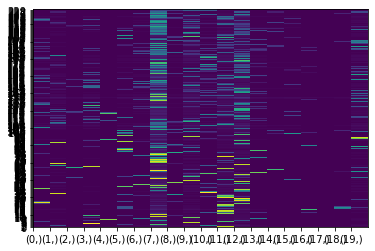

In [190]:
count=0

for a in data:
    doc_topic_weights = getDocTopicWeight(lda_model, a)
    for b in doc_topic_weights:
        # df_doctop = pd.DataFrame(b columns=range(20))
        df_doctop.at[count, b[0]] = b[1]

        # df_doctop.append(b[1]: doc_topic_weights)
    # print(doc_topic_weights[:][1])
    count=count+1

# Heatmap of weights
plt.pcolor(df_doctop)
plt.yticks(np.arange(0, len(df_doctop.index), 1), df_doctop.index)
plt.xticks(np.arange(0, len(df_doctop.columns), 1), df_doctop.columns)
plt.show()

df_doctop['Assertion']=data
df_doctop.to_csv("document_topic_weights.csv")

In [191]:
df_doctop

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Assertion
0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.044754,0.000000,0.011070,...,0.866799,0.016565,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,Access resources required to scale at relative...
1,0.011586,0.230957,0.0,0.012922,0.0,0.010839,0.013030,0.086780,0.010777,0.029980,...,0.032231,0.045561,0.010156,0.000000,0.0,0.0,0.0,0.000000,0.018967,Adapt offers to each market
2,0.000000,0.010264,0.0,0.000000,0.0,0.169120,0.000000,0.671501,0.000000,0.018260,...,0.019685,0.027586,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.011549,"Align interests of investors, the company top ..."
3,0.000000,0.124418,0.0,0.000000,0.0,0.236493,0.000000,0.046137,0.000000,0.132977,...,0.017364,0.368665,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.010218,Allow resource owners to make money using your...
4,0.000000,0.000000,0.0,0.949906,0.0,0.000000,0.000000,0.014035,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,Apply big data analytics to produce insightful...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,0.000000,0.010264,0.0,0.000000,0.0,0.000000,0.000000,0.186849,0.000000,0.018251,...,0.019591,0.412807,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.011549,Manage customer portfolio to develop and maint...
226,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.148129,0.507459,0.121128,0.016146,...,0.017359,0.024206,0.000000,0.000000,0.0,0.0,0.0,0.092633,0.010217,Make sure stakeholders reconcile divergent int...
227,0.000000,0.079310,0.0,0.000000,0.0,0.000000,0.000000,0.307123,0.000000,0.010242,...,0.011002,0.268687,0.000000,0.075855,0.0,0.0,0.0,0.000000,0.206364,Enable product co-creation so that both your c...
228,0.000000,0.079310,0.0,0.000000,0.0,0.000000,0.000000,0.306858,0.000000,0.010242,...,0.011002,0.268654,0.000000,0.075855,0.0,0.0,0.0,0.000000,0.206664,Enable product co-creation so that both your c...
